# ML1 Homework 3
**LT2: Alaan, Altonaga, Jalober, Ng**

---

## Import Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import warnings
def showwarning(*args, **kwargs):
    if args[1] is DeprecationWarning:
        return
    warnings._showwarning_orig(*args, **kwargs)
warnings.showwarning = showwarning

In [14]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
pd.options.display.float_format = '{:,.2g}'.format
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pylab as pl

## Load Dataset

In [4]:
fruits = pd.read_table('fruit_data_with_colors.txt')
fruits.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.6
3,2,mandarin,mandarin,86,6.2,4.7,0.8
4,2,mandarin,mandarin,84,6,4.6,0.79


In [5]:
print(fruits['fruit_name'].unique())

['apple' 'mandarin' 'orange' 'lemon']


In [6]:
print(fruits.shape)

(59, 7)


## Exploratory Data Analysis

### Statistical Summary

In [7]:
fruits.describe()

,fruit_label,mass,width,height,color_score
count,59,59,59,59,59
mean,2.5,1.6e+02,7.1,7.7,0.76
std,1.2,55,0.82,1.4,0.077
min,1,76,5.8,4,0.55
25%,1,1.4e+02,6.6,7.2,0.72
50%,3,1.6e+02,7.2,7.6,0.75
75%,4,1.8e+02,7.5,8.2,0.81
max,4,3.6e+02,9.6,10,0.93


We can see that the numerical values do not have the same scale. We will need to apply scaling to the test set that we computed for the training set.

### Fruit type distribution

In [8]:
print(fruits.groupby('fruit_name').size())

fruit_name
apple       19
lemon       16
mandarin     5
orange      19
dtype: int64


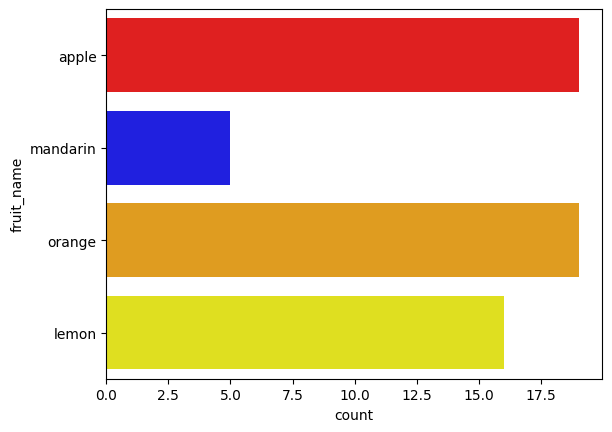

In [11]:
sns.countplot(fruits['fruit_name'], palette=["red", "blue", "orange", "yellow"], label="Count")
plt.show()

The data is pretty balanced except mandarin. We will just have to go with it. 

Box plot for each numeric variable will give us a clearer idea of the distribution of the input variables:

In [13]:
num_df = fruits.drop('fruit_label', axis=1).select_dtypes(include='number')
cols = list(num_df.columns)

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=cols[:4],  # adjust if >4 variables
    horizontal_spacing=0.08,  # ↓ tighter horizontally (default 0.2)
    vertical_spacing=0.08     # ↓ tighter vertically (default 0.3)
)

i = 0
for r in range(1, 3):
    for c in range(1, 3):
        if i < len(cols):
            colname = cols[i]
            fig.add_trace(
                go.Box(y=num_df[colname], name=colname, boxmean=True),
                row=r, col=c
            )
            i += 1

fig.update_layout(
    height=850, width=500,
    title=dict(
        text='Box Plot for each input variable',
        x=0.5, xanchor='center'
    ),
    showlegend=False,
    margin=dict(l=40, r=20, t=80, b=40),  # tighter margins
    font=dict(size=12)
)

fig.update_xaxes(title_text="")
fig.update_yaxes(title_text="Value")

# fig.write_html('fruits_boxplot.html')
fig.show()
# Optional: fig.write_image('fruits_boxplot.png', scale=2)

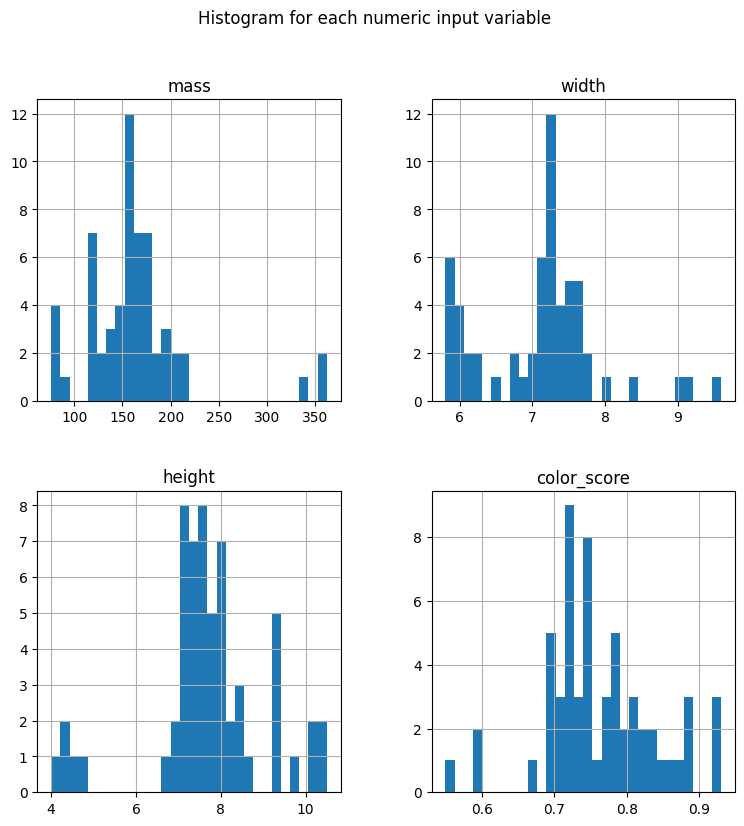

In [15]:
fruits.drop('fruit_label' ,axis=1).hist(bins=30, figsize=(9,9))
pl.suptitle("Histogram for each numeric input variable")
plt.savefig('fruits_hist')
plt.show()

It looks like perhaps color score has a near Gaussian distribution.

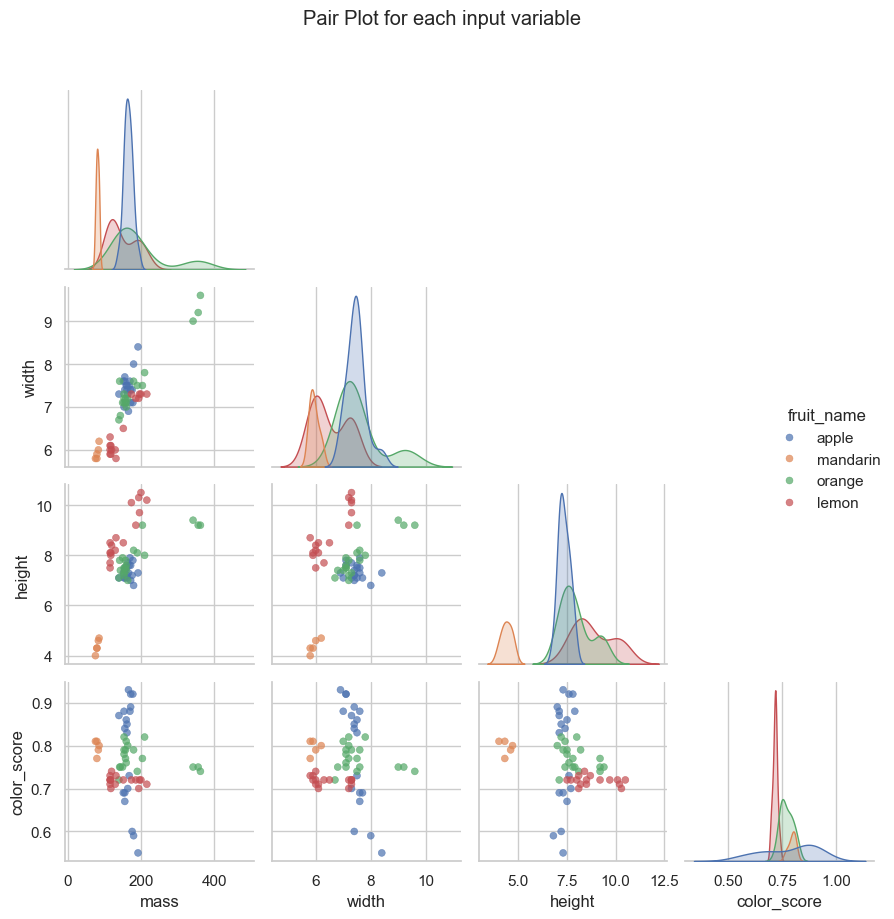

In [16]:
# numeric features only (exclude label)
num_cols = fruits.select_dtypes(include='number').columns.drop('fruit_label', errors='ignore')

sns.set_theme(style='whitegrid')
g = sns.pairplot(
    data=fruits,
    vars=num_cols,
    hue='fruit_name',
    diag_kind='kde',
    corner=True, 
    plot_kws=dict(s=25, alpha=0.7, edgecolor=None)
)

g.fig.set_size_inches(9, 9)
g.fig.suptitle('Pair Plot for each input variable', y=1.02)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.93)
g.savefig('fruits_pairplot.png', dpi=150, bbox_inches='tight')
plt.show()

### Correlation Heatmap Analysis

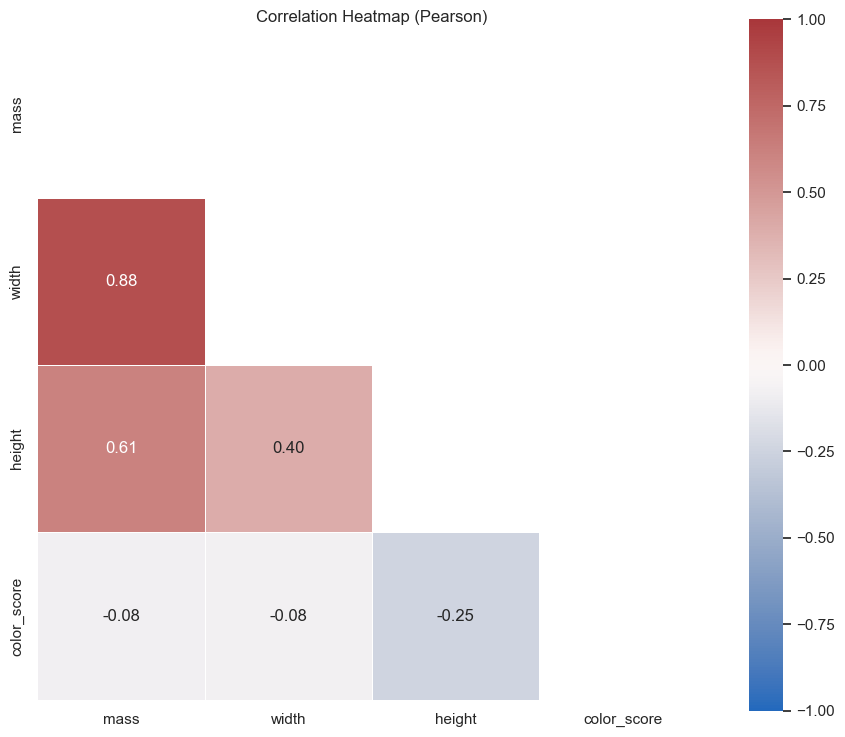

In [17]:
# numeric features only (exclude label if present)
num_df = fruits.drop(columns='fruit_label', errors='ignore').select_dtypes(include='number')

corr = num_df.corr(method='pearson')  # or 'spearman'
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style='white')
plt.figure(figsize=(9, 9))
ax = sns.heatmap(
    corr, mask=mask, cmap='vlag', vmin=-1, vmax=1,
    annot=True, fmt='.2f', square=True, linewidths=.5,
    cbar_kws=dict(shrink=.8)
)
plt.title('Correlation Heatmap (Pearson)')
plt.tight_layout()
plt.savefig('fruits_corr_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
# Tip: set annot=False if many features to declutter

Some pairs of attributes are correlated (mass and width). This suggests a high correlation and a predictable relationship

## Train and Test Split

In [18]:
feature_names = ['mass', 'width', 'height', 'color_score']
X = fruits[feature_names]
y = fruits['fruit_label']

## AutoML

In [19]:
Number_trials=20

def train_knn(X, y):
    score_train = []
    score_test = []

    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        neighbors_settings = range(1,40)
        acc_train = []
        acc_test = []

        for n_neighbors in neighbors_settings:
            clf = KNeighborsClassifier(n_neighbors=n_neighbors) # build the model
            clf.fit(X_train, y_train)
            acc_train.append(clf.score(X_train, y_train))
            acc_test.append(clf.score(X_test, y_test))

        score_train.append(acc_train)
        score_test.append(acc_test)

    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['kNN', np.amax(score), 'N_Neighbor = {0}'.format(np.argmax(score)+1), 'NA',run_time]

def train_logistic(X, y, reg):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000, 1e5, 1e8]
    #C = [.01, .1]
    score_train = []
    score_test = []
    weighted_coefs=[]

    for seed in range(Number_trials):
        training_accuracy = []
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        for alpha_run in C:
            if reg == 'l1':
                lr = LogisticRegression(C=alpha_run, penalty=reg, solver='liblinear').fit(X_train, y_train)
            if reg == 'l2':
                lr = LogisticRegression(C=alpha_run, penalty=reg, dual=False).fit(X_train, y_train)

            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_test, y_test))
            coefs=lr.coef_
            weighted_coefs.append(coefs) #append all the computed coefficients per trial

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)

    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials
    #print(mean_coefs)
    score = np.mean(score_test, axis=0)

    flat_coefs = np.abs(mean_coefs).ravel()[:len(X.columns)]
    top_predictor = X.columns[np.argmax(flat_coefs)]

    #Plot the weight of the parameters
    # top_predictor=X.columns[np.argmax(np.max(np.abs(mean_coefs), axis=0))]
    abs_mean_coefs = np.abs(mean_coefs[0,:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))

    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])

    run_time = (time.time() - start_time)
    return ['Logistic ({0})'.format(reg), np.amax(score), \
            'C = {0}'.format(C[np.argmax(score)]), top_predictor, run_time]

def train_svm(X, y, reg):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000, 1e5, 1e8]
    #C = [.01, .1]
    score_train = []
    score_test = []
    weighted_coefs=[]

    for seed in range(Number_trials):
        training_accuracy = []
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        for alpha_run in C:
            if reg == 'l1':
                svc = LinearSVC(C=alpha_run, penalty=reg, loss='squared_hinge', dual=False).fit(X_train, y_train)
            if reg == 'l2':
                svc = LinearSVC(C=alpha_run, penalty=reg).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.coef_
            weighted_coefs.append(coefs)

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)

    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials
    score = np.mean(score_test, axis=0)

    flat_coefs = np.abs(mean_coefs).ravel()[:len(X.columns)]
    top_predictor = X.columns[np.argmax(flat_coefs)]

    # top_predictor=X.columns[np.argmax(np.max(np.abs(mean_coefs), axis=0))]
    abs_mean_coefs = np.abs(mean_coefs[0,:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))

    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])

    run_time = (time.time() - start_time)
    return ['Linear SVM ({0})'.format(reg), np.amax(score), \
            'C = {0}'.format(C[np.argmax(score)]), top_predictor,run_time]

['kNN', np.float64(0.9466666666666667), 'N_Neighbor = 1', 'NA', 5.331701040267944]
5.331701040267944 seconds
['Logistic (l2)', np.float64(0.8233333333333335), 'C = 100000.0', 'width', 4.547276020050049]
4.547276020050049 seconds
['Logistic (l1)', np.float64(0.73), 'C = 5000', 'width', 1.859217882156372]
1.859217882156372 seconds
['Linear SVM (l2)', np.float64(0.7033333333333333), 'C = 100000.0', 'width', 1.6633350849151611]
1.6633350849151611 seconds
['Linear SVM (l1)', np.float64(0.7), 'C = 100', 'width', 1.8610179424285889]
1.8610179424285889 seconds


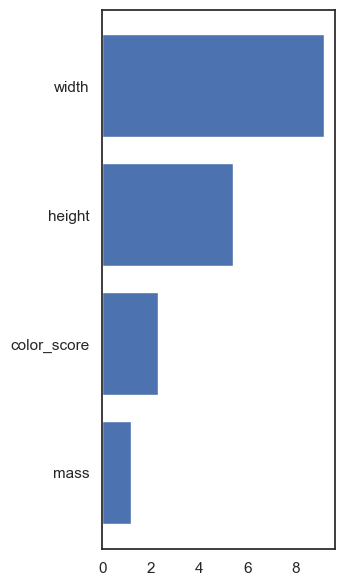

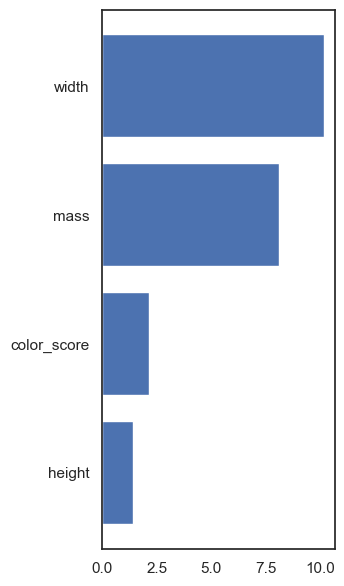

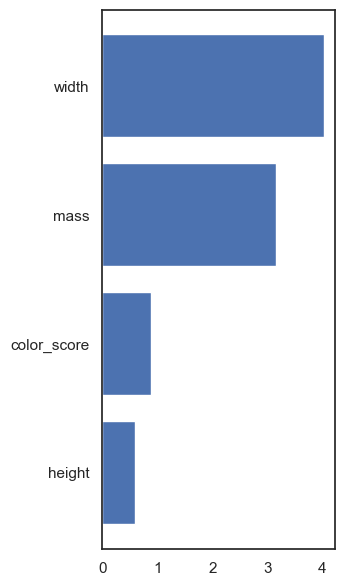

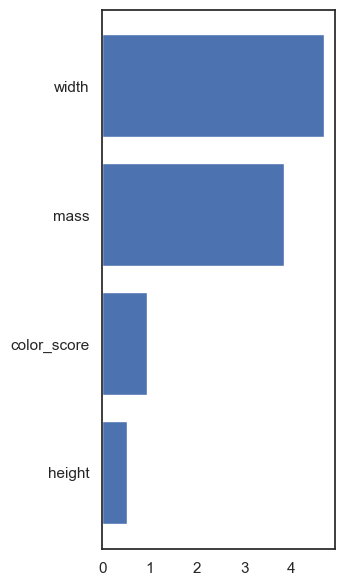

In [20]:
import time

start_time = time.time()
a = train_knn(X,y)
print(a)
print("%s seconds" % a[4])

start_time = time.time()
b = train_logistic(X,y,reg='l2')
print(b)
print("%s seconds" % b[4])

start_time = time.time()
c = train_logistic(X,y,reg='l1')
print(c)
print("%s seconds" % c[4])

start_time = time.time()
d = train_svm(X,y,reg='l2')
print(d)
print("%s seconds" % d[4])

start_time = time.time()
e = train_svm(X,y,reg='l1')
print(e)
print("%s seconds" % e[4])

In [21]:
from sklearn.model_selection import GridSearchCV

def train_rf(X, y):
    score_train = []
    score_test = []
    best_params = []
    best_estimators = []

    for seed in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        param_grid = {
        'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
        'max_depth': list(range(1, 6)),      # Maximum depth of individual trees
        'max_features': ['sqrt'] # Number of features to consider when looking for the best split
        }

        rf = RandomForestClassifier(random_state=0)
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        score_train.append(grid_search.score(X_train, y_train))
        score_test.append(grid_search.score(X_test, y_test))
        best_params.append(grid_search.best_params_)
        best_estimators.append(grid_search.best_estimator_)

    best_estimator = best_estimators[np.argmax(score_test)]
    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['Random Forest', np.amax(score), str(best_params[np.argmax(score_test)]), \
            X.columns[np.argmax(best_estimator.feature_importances_)], run_time]

In [22]:
start_time = time.time()
f = train_rf(X,y)
print(f)
print("%s seconds" % f[4])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
['Random Forest', np.float64(0.9400000000000001), "{'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 50}", 'color_score', 70.20409917831421]
70.20409917831421 seconds


In [23]:
def train_gbm(X, y):
    score_train = []
    score_test = []
    best_params = []
    best_estimators = []

    for seed in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        param_grid = {
        'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]    # Learning Rate
        }

        gbm = GradientBoostingClassifier(random_state=0)
        grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        score_train.append(grid_search.score(X_train, y_train))
        score_test.append(grid_search.score(X_test, y_test))
        best_params.append(grid_search.best_params_)
        best_estimators.append(grid_search.best_estimator_)

    best_estimator = best_estimators[np.argmax(score_test)]
    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['Gradient Boosting Method', np.amax(score), str(best_params[np.argmax(score_test)]), \
            X.columns[np.argmax(best_estimator.feature_importances_)], run_time]

In [24]:
start_time = time.time()
g = train_gbm(X,y)
print(g)
print("%s seconds" % g[4])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
['Gradient Boosting Method', np.float64(0.8866666666666667), "{'learning_rate': 0.5, 'n_estimators': 50}", 'color_score', 107.43884801864624]
107.43884801864624 seconds


## Summary of Results (AutoML)

In [25]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable', 'Run Time']
df = pd.DataFrame(columns=cols)

df.loc[0] = a
df.loc[1] = b
df.loc[2] = c
df.loc[3] = d
df.loc[4] = e
df.loc[5] = f
df.loc[6] = g

df

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,kNN,0.95,N_Neighbor = 1,NA,5.3
1,Logistic (l2),0.82,C = 100000.0,width,4.5
2,Logistic (l1),0.73,C = 5000,width,1.9
3,Linear SVM (l2),0.7,C = 100000.0,width,1.7
4,Linear SVM (l1),0.7,C = 100,width,1.9
5,Random Forest,0.94,"{'max_depth': 4, 'max_features': 'sqrt', 'n_es...",color_score,70
6,Gradient Boosting Method,0.89,"{'learning_rate': 0.5, 'n_estimators': 50}",color_score,1.1e+02


In [26]:
df.iloc[5, 2]

"{'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 50}"